**This jupyter notebook demonstrates how to:**

1. Dataframes concatenation for final dataset;
2. Data preparation for CNN model training;
3. Split during training to avoid Colab memory overflow;
4. 

**Mount google drive to access files**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
import datetime
from math import pow
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, TimeDistributed, Masking
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import tensorflow as tf

  

  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Models and datasets dirs
DATASETS_DIR = r'/content/gdrive/My Drive/datasets/'
MODEL_FOLDER = 'classification/'
MODELS_DIR = DATASETS_DIR + MODEL_FOLDER

In [ ]:
def display_lr(lr_schedule, nb_epochs):
  x = np.arange(nb_epochs)
  y = [lr_schedule(i) for i in x]
  plt.figure(figsize=(9,5))
  plt.plot(x,y)
  plt.title("Learning rate schedule\nmax={:.2e}, min={:.2e}".format(np.max(y), np.min(y)),
            y=0.85)
  plt.show()



**Weather stations data**

Files where downloaded from http://www.inmet.gov.br/portal/index.php?r=bdmep/bdmep

Weather data are related to Sewage Lift Stations events because because part of the rainwater is improperly connected to the sewer network.

This dataset is composed by data from 9 weather stations wich are located in Belo Horizonte region. They are near sewage lift stations analysed at this master degree work.

Each weather station file contains daily precipitation between January 1, 2010 and December 31, 2018.


In [ ]:
#load weather stations register containing ids from all weather stations
weather_stations = pd.read_csv(DATASETS_DIR + r'cadastro_estacoes.csv')

#load 9 weather stations datasets
weather_stations_data_list = []
for i,row in weather_stations.iterrows():
    #load the dataset from each weather station 
    #files names uses the id from each weather station
    weather_station_data = pd.read_csv(DATASETS_DIR + r'estacao_{0}.csv'.format(row['id']),delimiter=';')
    #set the datetime index
    weather_station_data['datahora'] = pd.to_datetime(weather_station_data['Data'],format='%d/%m/%Y')
    weather_station_data.index = pd.to_datetime(weather_station_data['datahora'])
    #change the precipitation column name preparing for concatenation
    new_column_name = f"WeatherStation_{row['id']}"
    weather_station_data = weather_station_data.rename(columns = {'Precipitacao':new_column_name})
    #append each weather station dataset to a list for letter concatenation
    weather_stations_data_list.append(weather_station_data[['datahora',new_column_name]])

#contatenate weather station datasets    
weather_stations_datas = pd.concat(weather_stations_data_list, axis=1)
weather_stations_datas = weather_stations_datas.drop(columns=['datahora',])
#fill values na with 0
weather_stations_datas = weather_stations_datas.fillna(0)

**Load lift stations register**

This data frame contains characteristics and specifications about sewage lift stations

Some columns (listed above) contains float values with comma instead of dot. 

In [ ]:
lift_station_register = pd.read_csv(DATASETS_DIR + r'sewage_pumping_stations_base.csv')

#list of columns to transform into float, changing comma for dot
columns_to_change_to_float = ['utmx', 'utmy', 'nivel_max','vazao_recalque', 
                              'altura_manometrica','extensao_recalque',
                              'potencia_instalada']

for column in columns_to_change_to_float:
  try:
    lift_station_register[column] = lift_station_register[column].str.replace(',', '.').astype(float)
  except:
    print(f'Erro changing type of column: {column}')
    continue

register_without_strings = lift_station_register.copy()

tmp = cadastro_sem_strings.select_dtypes(exclude=[np.number])

# integer encode
label_encoder = LabelEncoder()
for column in tmp.columns:
    integer_encoded = label_encoder.fit_transform(tmp[column])
    cadastro_sem_strings[column] = integer_encoded

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
HOURS_BEFORE = 8
HOURS_AFTER  = 1

def getTimeseriesFromElevatoria(elevatoria, years=None):
  timeseries_file   = DATASETS_DIR + f'timeseries_elevatoria_{elevatoria}.csv'
  #realiza leitura de arquivo csv, configura frequencia, renomeia coluna e cria coluna de data para deixar identico ao timeseries original
  timeseries   = pd.read_csv(timeseries_file, parse_dates=['TIMESTAMP','TIMESTAMP.1', 'TIMESTAMP_fim'], index_col=0)
  timeseries = timeseries.rename(columns={'TIMESTAMP.1': 'TIMESTAMP',}).asfreq('5T')
  timeseries['DATA'] = timeseries.index.date
  
  if years != None:
    timeseries = timeseries[timeseries.TIMESTAMP.dt.year.isin(years)]
  
  #calcula soma do tempo de extravasao para a proxima 1h (12x5 minutos)
  timeseries['extravasao_duracao_after'] = timeseries['extravasao_duracao'].rolling(min_periods=1, window=HOURS_AFTER*12).sum().shift(-HOURS_AFTER*12)
  timeseries['extravasao_duracao_before'] = timeseries['extravasao_duracao'].rolling(min_periods=1, window=HOURS_BEFORE*12).sum()

  #filtra apenas as que não tiveram extravasao nas ultimas 8h para garantir que a predição não é contaminada 
  #(prever a extravasão sem saber que há uma extravasão ocorrendo tem mais valor)
  #timeseries = timeseries[timeseries.extravasao_duracao_before == 0]
    
  create_features(timeseries)

  #cria coluna em dados de estacoes metereologicas e une dados a estacao
  dados_estacoes['DATA'] = dados_estacoes.index.date
  timeseries = pd.merge(timeseries, dados_estacoes,on='DATA')    
    
  #varre cada uma das colunas do cadastro criando novas colunas (categorical data) na serie temporal
  for column in cadastro_sem_strings.columns:
    timeseries[column] = cadastro_sem_strings.iloc[elevatoria - 1][column]

  #conta quantidade de valores nulos nas proximas 8h  
  timeseries['isnull']          = 0
  timeseries.loc[timeseries.nivel.isnull(), 'isnull'] = 1
  timeseries['contagem_valores_nulos_prox_8h']          = timeseries['isnull'].rolling(min_periods=1, window=8*12).sum().shift(8*12)    
    
  #marca valores nan com -1
  #timeseries = timeseries.fillna(-1)
  
  #seta valor de colunas de saida = 0 caso valor seja menor que 0
  #timeseries.loc[timeseries['extravasao_duracao_after'] < 0, 'extravasao_duracao_after'] = 0.0
  #timeseries.loc[timeseries['extravasao_duracao_before'] < 0, 'extravasao_duracao_before'] = 0.0
  
  
  #converte valor das colunas de duracao para horas
  for col in timeseries.columns:
    if 'duracao' in col:
      #transforma para horas
      timeseries[col] = timeseries[col] * 1.0/ 3600
  
  
  #remove linhas em que, ao menos metade das 8h proximas, possuem valor nulo
  #timeseries = timeseries[timeseries.contagem_valores_nulos_prox_8h < 48]

  return timeseries 


In [ ]:
# multivariate output data prep


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

 

def prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps = 96):
    """
    prepara serie temporal para fit do modelo
    n_steps com valor defaul de 96 considerando 8 horas (12 registros de 5min/hora => 12*8)
    """
    #tamanho dos vetores
    size_of_arrays = len(timeseries.index)

    #sequencias de entradas e saídas convertidas em estruturas de [linhas, colunas]
    in_seqs  = [timeseries[col].values.reshape((size_of_arrays, 1)) for col in input_columns]
    out_seqs = [timeseries[col].values.reshape((size_of_arrays, 1)) for col in output_columns]

    # horizontally stack columns
    dataset = np.hstack(tuple(in_seqs + out_seqs))


    # convert into input/output
    X, y = split_sequences(dataset, n_steps)

    return X, y

#cria lista de nomes de colunas sem saida
output_columns    = ['tipo_extravasao',]
columns_to_remove = ['DATA','TIMESTAMP','TIMESTAMP_fim','date', 'nivel_inv_max', 'corrente1_inv_max', 
                     'corrente2_inv_max', 'corrente3_inv_max', 'extravasao_ocorreu', 'extravasao_ocorrendo', 
                    'acc_bomba1_ocorreu', 'acc_bomba1_ocorrendo', 'acc_bomba2_ocorreu', 'acc_bomba2_ocorrendo',
                    'acc_bomba3_ocorreu', 'acc_bomba3_ocorrendo','mnt_bomba1_ocorreu', 'mnt_bomba1_ocorrendo',
                    'mnt_bomba2_ocorreu', 'mnt_bomba2_ocorrendo', 'mnt_bomba3_ocorreu', 'mnt_bomba3_ocorrendo',
                     'extravasao_duracao_before','contagem_valores_nulos_prox_8h', 'isnull', 'extravasao_duracao_after',]
#input_columns     = [k for k in timeseries.columns if k not in output_columns + columns_to_remove]
input_columns = [
  'nivel', 'corrente1', 'corrente2', 'corrente3', 'extravasao_contagem', 
 'extravasao_duracao', 'extravasao_contagem_cum', 'extravasao_duracao_cum',
 'extravasao_ocorreu_cum', 'extravasao_ocorrendo_cum', 'acc_bomba1_contagem',
 'acc_bomba1_duracao', 'acc_bomba1_contagem_cum', 'acc_bomba1_duracao_cum',
 'acc_bomba1_ocorreu_cum', 'acc_bomba1_ocorrendo_cum', 'mnt_bomba1_contagem',
 'mnt_bomba1_duracao', 'mnt_bomba1_contagem_cum', 'mnt_bomba1_duracao_cum',
 'mnt_bomba1_ocorreu_cum', 'mnt_bomba1_ocorrendo_cum', 'acc_bomba2_contagem',
 'acc_bomba2_duracao', 'acc_bomba2_contagem_cum', 'acc_bomba2_duracao_cum',
 'acc_bomba2_ocorreu_cum', 'acc_bomba2_ocorrendo_cum', 'mnt_bomba2_contagem',
 'mnt_bomba2_duracao', 'mnt_bomba2_contagem_cum', 'mnt_bomba2_duracao_cum',
 'mnt_bomba2_ocorreu_cum', 'mnt_bomba2_ocorrendo_cum', 'acc_bomba3_contagem',
 'acc_bomba3_duracao', 'acc_bomba3_contagem_cum', 'acc_bomba3_duracao_cum',
 'acc_bomba3_ocorreu_cum', 'acc_bomba3_ocorrendo_cum', 'mnt_bomba3_contagem',
 'mnt_bomba3_duracao', 'mnt_bomba3_contagem_cum', 'mnt_bomba3_duracao_cum',
 'mnt_bomba3_ocorreu_cum', 'mnt_bomba3_ocorrendo_cum',
 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
 'weekofyear', 'Precipitacao_83581', 'Precipitacao_83570', 'Precipitacao_83536', 
 'Precipitacao_83533', 'Precipitacao_83635', 'Precipitacao_83632',
 'Precipitacao_83586', 'Precipitacao_83589', 'Precipitacao_83587',
 'indice', 'nome', 'utmx', 'utmy', 'Tipo de bomba', 'Quantidade de bombas', 
 'Vazão de recalque (l/s)', 'Altura manométrica (mca)', 
 'Diâmetro tubulação   recalque (mm)',  'Material  tubulação  recalque', 
 'Extensão  tubulação  recalque(m)', 'Retenção  resíduos', 
 'Sistema Içamento  bombas ', 'Urbanização', 'Potência instalada (cv)', 
 'Combate a odores', 'Sistema de partida das bombas',
 'Tipo de sensor de nível utilizado no controle', 'nivel_max', 
 'corrente1_max', 'corrente2_max', 'corrente3_max', 'bomba1', 'bomba2', 'bomba3']

valid_columns = input_columns + output_columns

#8 horas de dados
n_steps = 96
n_features = len(input_columns) # a quantidade de features está presente nas entradas
n_outputs  = 3 #opcoes de classificacao (sim, não e invalido)
n_batch    = n_steps #1 período de 8 horas



In [ ]:
n_features

88

In [ ]:

def get_timeseries_from_elevatoria(elevatoria, years):
  timeseries        = getTimeseriesFromElevatoria(elevatoria,years=years)
  timeseries['tipo_extravasao'] = 'nao'
  timeseries.loc[timeseries['extravasao_duracao_after'] > 0, 'tipo_extravasao'] = 'sim'
  timeseries.loc[timeseries.contagem_valores_nulos_prox_8h >= 48, 'tipo_extravasao'] = 'invalido'


  scaler_dict = {}

  #normaliza todas as colunas validas entre 0 e 1
  for column in input_columns:
    #values = timeseries[[column]].values
    min_max_scaler = MinMaxScaler()
    null_index = timeseries[column].isnull()
    timeseries.loc[~null_index, column] = min_max_scaler.fit_transform(timeseries.loc[~null_index, [column]])
    #timeseries[column] = min_max_scaler.fit_transform(values)
    scaler_dict[column] = min_max_scaler

  #marca valores nan com -1
  timeseries = timeseries.fillna(-1) 

  return timeseries 
  

In [ ]:
def encode_output(train_y, test_y):
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(np.array(['nao', 'sim', 'invalido']))
  encoded_Y = encoder.transform(train_y)
  encoded_test_Y = encoder.transform(test_y)
  return to_categorical(encoder.transform(train_y)), \
          to_categorical(encoder.transform(test_y)),\
          encoded_Y,\
          encoded_test_Y

In [ ]:
def dummy_prepare_input(input):
  """
  função dummy que não altera entrada
  """
  return input
prepare_function_by_model = {}
prepare_function_by_model['cnn_dense_100'] = dummy_prepare_input


In [ ]:
#dicionario de modelos
models = {}

# define the CNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(n_steps,n_features)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',  
              metrics=['accuracy'])
models['cnn_dense_100'] = model

model_name = 'cnn_dense_100'
model = models[model_name]

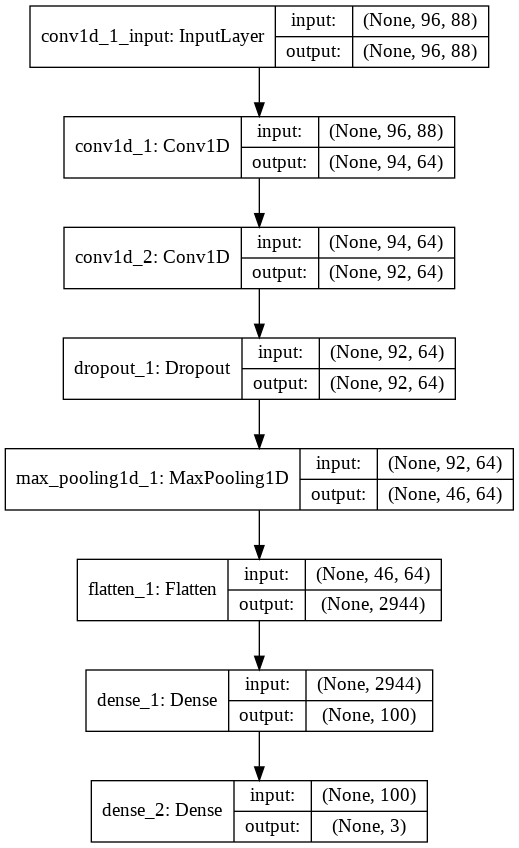

In [ ]:
#imagem detalhando o modelo cnn
plot_model(models['cnn_dense_100'], to_file='model_cnn_dense_100.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Keras model callbacks

# This callback records a per-step loss history instead of the average loss per
# epoch that Keras normally reports. It allows you to see more problems.
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.history = {'loss': []}
  def on_batch_end(self, batch, logs={}):
      self.history['loss'].append(logs.get('loss'))
      
# This callback resets the RNN state at each epoch
class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, batch, logs={}):
      self.model.reset_states()
      print('reset state')

reset_state = ResetStateCallback()
      
# learning rate decay callback
#def lr_schedule(epoch): return 0.01
def lr_schedule(epoch): return 0.0001 + 0.01 * pow(0.65, epoch)
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)


full_history = LossHistory()
'''
saves the model weights after each epoch if the validation loss decreased
'''
best_file_path = MODELS_DIR + f"best_{model_name}" +"_weights.{epoch:02d}-{val_loss:.hdf5}.h5"
checkpointer = ModelCheckpoint(filepath=best_file_path, verbose=1, save_best_only=True)


In [ ]:
NB_EPOCHS = 10

In [ ]:
# this prints a description of the model
models['cnn_dense_100'].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 94, 64)            16960     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 46, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2944)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               294500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 94, 64)            16960     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 46, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2944)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               294500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

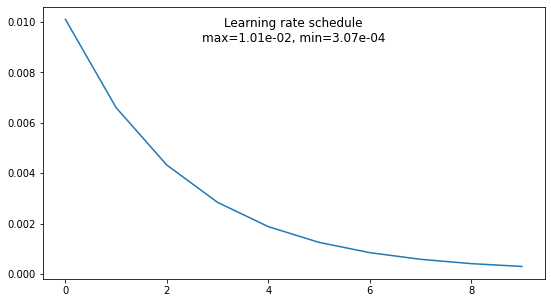

In [ ]:
epoch = 1
if epoch > 1:
  model.load_weights(MODELS_DIR + f"{model_name}_invclass_{elevatoria}_epoch{epoch - 1}_batch{n_batch}.h5")

# this prints a description of the model
model.summary()

display_lr(lr_schedule, NB_EPOCHS)



In [ ]:
history_elevatorias = {}
epoch = 9

In [ ]:

timeseries = get_timeseries_from_elevatoria(1, [2018,])
print(timeseries.shape)

#preparacao dos dados de treinamento e teste
train_x, train_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)
print(train_x.shape)
print(train_y.shape)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(train_y, train_y)
print(train_y.shape)
print(test_y.shape)
print(encoded_Y.shape)
print(encoded_test_Y.shape)

prepare_input_function = prepare_function_by_model[model_name]
print(prepare_input_function(train_x).shape)

(8895, 115)
(8800, 96, 88)
(8800,)
(8800, 3)
(8800, 3)
(8800,)
(8800,)
(8800, 96, 88)


In [ ]:
#elevatorias_escolhidas = [1, 22, 25] #apenas autoescorvantes
elevatorias_escolhidas = [1,10,11,12,25] #vários tipos de bombas
epoch = 1
for nepoch in range(NB_EPOCHS):
  epoch +=1
  for year in [2016,2017,2018]:
    print(f'Epoca {epoch} - ano {year}')      
    for elevatoria in elevatorias_escolhidas:
      print(f'Treinando dados da elevatoria {elevatoria}...')
      timeseries = get_timeseries_from_elevatoria(elevatoria, [year,])

      #preparacao dos dados de treinamento e teste
      train_x, train_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

      #encode for classification task
      train_y, test_y, encoded_Y, encoded_test_Y = encode_output(train_y, train_y)
      
      full_history = LossHistory()
      
      # fit network
      number_of_epochs = NB_EPOCHS
      prepare_input_function = prepare_function_by_model[model_name]
      history  = model.fit(prepare_input_function(train_x), 
                          encoded_Y, 
                          batch_size=n_batch, 
                          epochs=1, 
                          #validation_data=(prepare_input_function(test_x), encoded_test_Y), 
                          verbose=1,
                          callbacks=[full_history,])
      model.save(MODELS_DIR + f"{model_name}_{elevatoria}_epoch{epoch}_batch{n_batch}_{year}_complete_1htest_autoescorvantes.h5")
      try:
        history_elevatorias[elevatoria]['history'].append(history)
        history_elevatorias[elevatoria]['full_history'].append(full_history)
      except:
        history_elevatorias[elevatoria] = {}
        history_elevatorias[elevatoria]['history'] =[]
        history_elevatorias[elevatoria]['history'] = [history,]
        history_elevatorias[elevatoria]['full_history'] =[]
        history_elevatorias[elevatoria]['full_history'] = [full_history,]
        pass
      test_y = None
      test_x = None
      train_x = None
      train_y = None
      train = None
      test = None
      timeseries = None
      encoded_Y = None
      encoded_test_Y = None
      import gc
      gc.collect()


Epoca 2 - ano 2016
Treinando dados da elevatoria 1...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





105313/105313 [==============================] - 51s 487us/step - loss: 0.1309 - acc: 0.9637
Treinando dados da elevatoria 22...
Epoch 1/1
105313/105313 [==============================] - 37s 347us/step - loss: 0.1687 - acc: 0.9456
Treinando dados da elevatoria 25...
Epoch 1/1
105313/105313 [==============================] - 36s 343us/step - loss: 0.1530 - acc: 0.9532
Epoca 2 - ano 2017
Treinando dados da elevatoria 1...
Epoch 1/1
105025/105025 [==============================] - 36s 346us/step - loss: 0.1225 - acc: 0.9668
Treinando dados da elevatoria 22...
Epoch 1/1
105025/105025 [==============================] - 36s 346us/step - loss: 0.1233 - acc: 0.9648
Treinando dados da elevatoria 25...
Epoch 1/1
105025/105025 [==============================] - 36s 342us/step - loss: 0.1694 - acc: 0.9463
Epoca 2 - ano 2018
Treinando

In [ ]:
year = 2018
epoch = 9
elevatoria = 25
model.load_weights(MODELS_DIR + f"{model_name}_{elevatoria}_epoch{epoch}_batch{n_batch}_{year}_complete.h5")

In [ ]:
def print_accuracy_and_confusion_matrix(model, test_x, test_y, encoded_test_y, n_batch):
  loss , accuracy = model.evaluate(test_x, encoded_test_y, batch_size=n_batch, verbose=1)
  print('loss: {}   - accuracy: {} '.format(loss,accuracy))

  predicted = model.predict(test_x, verbose=0)
  y_pred= (predicted>0.5) 
  cm = multilabel_confusion_matrix(test_y, y_pred)
  print(cm)
  print(classification_report(test_y,y_pred))

In [ ]:




test_y = None
test_x = None
train_x = None
train_y = None
train = None
test = None
timeseries = None
encoded_Y = None
encoded_test_Y = None
import gc
gc.collect()


timeseries = get_timeseries_from_elevatoria(13, [2016,2017,2018])

#preparacao e separacao dos dados 
test_x, test_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(test_y, test_y)

print_accuracy_and_confusion_matrix(model, test_x, test_y, encoded_Y, n_batch)

predicted = model.predict(test_x, verbose=0)

con = tf.math.confusion_matrix(labels=encoded_Y, predictions=np.argmax(predicted, axis=1) )
tf.print(con)

269767/269767 [==============================] - 72s 268us/step
loss: 1.049816236424604   - accuracy: 0.8022775053977966 
[[[265905    445]
  [  2175   1242]]

 [[ 32103   5386]
  [ 47426 184852]]

 [[188251  47444]
  [  3797  30275]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      0.36      0.49      3417
           1       0.97      0.80      0.88    232278
           2       0.39      0.89      0.54     34072

   micro avg       0.80      0.80      0.80    269767
   macro avg       0.70      0.68      0.63    269767
weighted avg       0.90      0.80      0.83    269767
 samples avg       0.80      0.80      0.80    269767



In [ ]:
test_y = None
test_x = None
train_x = None
train_y = None
train = None
test = None
timeseries = None
encoded_Y = None
encoded_test_Y = None
import gc
gc.collect()


timeseries = get_timeseries_from_elevatoria(12, [2016,2017,2018])

#preparacao e separacao dos dados 
test_x, test_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(test_y, test_y)

print_accuracy_and_confusion_matrix(model, test_x, test_y, encoded_Y, n_batch)

predicted = model.predict(test_x, verbose=0)

con = tf.math.confusion_matrix(labels=encoded_Y, predictions=np.argmax(predicted, axis=1) )
tf.print(con)

269766/269766 [==============================] - 68s 254us/step
loss: 0.3118222669991094   - accuracy: 0.9262027144432068 
[[[267180    388]
  [  1412    786]]

 [[ 49845   6702]
  [ 13148 200071]]

 [[202634  12783]
  [  5392  48957]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      0.36      0.47      2198
           1       0.97      0.94      0.95    213219
           2       0.79      0.90      0.84     54349

   micro avg       0.93      0.93      0.93    269766
   macro avg       0.81      0.73      0.75    269766
weighted avg       0.93      0.93      0.93    269766
 samples avg       0.93      0.93      0.93    269766

[[789 1325 84]
 [390 200111 12718]
 [0 5391 48958]]


In [ ]:
print_accuracy_and_confusion_matrix(model, test_x, test_y, encoded_Y, n_batch)

269766/269766 [==============================] - 80s 298us/step
loss: 0.3118222669991094   - accuracy: 0.9262027144432068 
[[[267180    388]
  [  1412    786]]

 [[ 49845   6702]
  [ 13148 200071]]

 [[202634  12783]
  [  5392  48957]]]
              precision    recall  f1-score   support

           0       0.67      0.36      0.47      2198
           1       0.97      0.94      0.95    213219
           2       0.79      0.90      0.84     54349

   micro avg       0.93      0.93      0.93    269766
   macro avg       0.81      0.73      0.75    269766
weighted avg       0.93      0.93      0.93    269766
 samples avg       0.93      0.93      0.93    269766



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
